# Метод опорных векторов (Support Vector Machine)

In [37]:
from __future__ import print_function

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, LabelEncoder, MinMaxScaler, LabelBinarizer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

import xgboost as xgb

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings("ignore")

Уравнение прямой задаётся как: $$g(x) = w_0 + w_1x_1 + w_2x_2 = w_0 + \langle w, x \rangle = w_0 +  w^\top x $$

* Если $g(x^*) > 0$, то $y^* = \text{'черный'} = +ve$
* Если $g(x^*) < 0$, то $y^* = \text{'зеленый'} = -ve$
* Если $g(x^*) = 0$, то мы находимся на линии
* т.е. решающее правило: $y^* = sign(g(x^*))$

Некоторые геометрические особенности
* $\frac{|g(x)|}{||w||}$ - расстояние от точки $x$ до гиперплоскости, степень "уверенности" в классификациий
* Величину $M = y(\langle w, x \rangle + w_0) = y \cdot g(x)$ называют **отступом**(margin)

Если для какого-то объекта $M \geq 0$, то его классификация выполнена успешно.

$$L(w) = \sum_i [y^{(i)} (\langle w, x^{(i)} \rangle + w_0) < 0] \rightarrow \min_{w, w_0}$$

###  Линейноразделимый случай с двумя классами
* Заметим что $g(x) = w_0 + \langle w, x \rangle$ и $g'(x) = c \cdot (w_0 + \langle w, x \rangle)$, $\forall c>0$ задают одну и ту же гиперплоскость
* Подберем $c$ таким образом, чтобы $\min\limits_i M_i = \min\limits_i y \cdot g(x_i) = 1$

.<img src="./../pics/margin.png"  width="150%" height="130%">

* Таким образом выполняются следующие неравенства:
    * $w_0 + \langle w, x_i \rangle \geq 1$, если $y_i = + 1$
    * $w_0 + \langle w, x_i \rangle \leq - 1$, если $y_i = - 1$
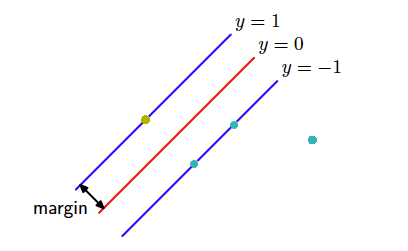

* Разделяющая полоса:  $ -1 \leq w_0 + \langle w, x \rangle \leq +1$
* Ширина разделяющей полосы:
 $$\langle (x_{+} -  x_{-}) , \frac{w}{||w||}\rangle = \frac{\langle w, x_{+} \rangle - \langle w, x_{-} \rangle }{||w||} = \frac{2}{||w||}  \rightarrow \max$$
 
 
* Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2  \rightarrow \min  \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 \quad i=1\dots n
\end{cases}
$$

По теореме Куна-Таккера:


$$\begin{cases} 
   \mathcal{L}(w,w_0,\lambda) = \frac{1}{2} ||w||^2  - \sum\limits_i \lambda_i \left( y^{(i)}(\langle w, x \rangle + w_0 )  - 1\right)  \rightarrow \min\limits_{w,w_0}\max\limits_{\lambda}  \\
   \lambda_i \geq 0 \quad i=1\dots n\\
   \lambda_i = 0 \text{, либо }  \langle w, x^{(i)} \rangle + w_0 = y^{(i)} \quad i=1\dots n
\end{cases}$$
Объекты, для которых  $\lambda_i \neq 0$ называются **опорными**


Необходимое условие:
*  $\frac{\partial \mathcal{L} }{\partial w} = w - \sum\limits_i \lambda_iy_ix_i = 0 \quad \Rightarrow  \quad w = \sum\limits_i \lambda_iy_ix_i$
*  $\frac{\partial \mathcal{L} }{\partial w_0} = \sum\limits_i \lambda_iy_i = 0$

(Сопряжённая задача) Если подставить  эти результаты в $\mathcal{L}$ то получится
$$\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle x_i, x_j \rangle)  \rightarrow \max\limits_\lambda  \\
\lambda_i \geq 0 \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}$$

* **Зависит не от самих объектов, а от их скалярного произведения!**
* $\mathcal{L}(\lambda)$ - выпуклая и ограниченная сверху функция.
* Имеем единственное решение при линейной разделимости
* Находим $\lambda_i,$ из $w = \sum\limits_i \lambda_iy_ix_i$ находим коэффициенты $w$.
* Свободный член $w_0$ определяется как среднее или медиана $\{\langle w, x_i \rangle - y_i: \lambda_i \neq 0\}$

In [40]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


def plot_svc_log_decision_function(clf1, clf2, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    P2 = clf2.decision_function(XY)
    P2 = P2.reshape(XX.shape)
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    
    ax.contour(XX, YY, P2, colors='r', label='logreg',
               levels=[0], alpha=0.5,
               linestyles=['-'])

    
def plot_svc_decision_function(clf1, ax=None):
    if ax is None:
        ax = plt.gca()
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    XX, YY = np.meshgrid(x, y)
    XY = np.c_[XX.ravel(), YY.ravel()]
    P1 = clf1.decision_function(XY)
    P1 = P1.reshape(XX.shape)
    
    cplot = ax.contour(XX, YY, P1, colors='k', label='svm',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    ax.clabel(cplot, inline=1, fontsize=10)
    

def lin_sep_svm_demo(class_sep=2):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)

    lin_svm = SVC(kernel='linear', C=10).fit(X, y)
    
    log_reg = LogisticRegression(C=10).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_log_decision_function(lin_svm, log_reg)

    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

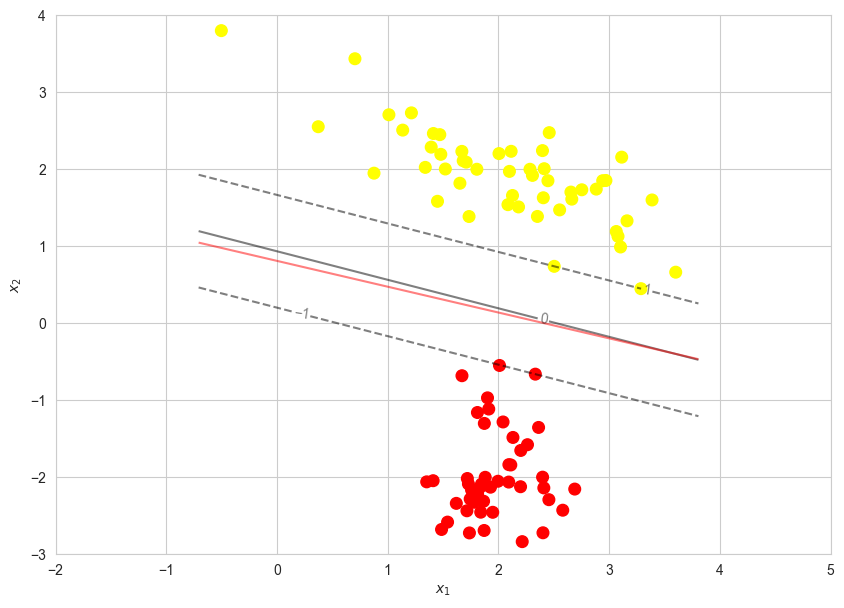

In [41]:
lin_sep_svm_demo(2);

### Неразделимый случай 

Будем допускать пропуск объектов за разделительную линию
* Вместо условия $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1$
* Будет условие $y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i, \quad \xi_i \geq 0$



А целевой функционал заменим на 

$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $
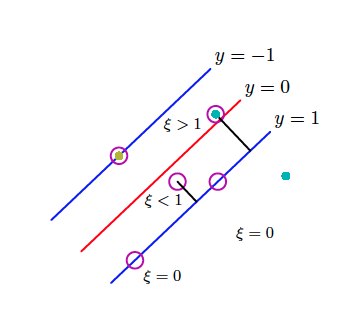

<br>

!<img src="./../pics/nonseparable.png"  width="360%" height="330%">

</br>

Таким образом мы придем к оптимизационной задаче:
$$
\begin{cases} 
   \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi} \\
   y^{(i)}(\langle w, x^{(i)} \rangle + w_0 ) \geq 1 - \xi_i \quad i=1\dots n \\
   \xi_i \geq 0 \quad i=1\dots n
\end{cases}
$$


Условия Куна-Таккера, необходимые условия оптимума $\rightarrow$ получаем сопряженную задачу
$$\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle x_i, x_j \rangle)  \rightarrow \max\limits_\lambda  \\
0 \leq \lambda_i \leq C \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}$$

Заметим, что изначальный целевой функционал
$$ \frac{1}{2} ||w||^2 + C\sum\limits_i\xi_i  \rightarrow \min\limits_{w,w_0,\xi}  $$
Можно представить в виде
$$ \frac{1}{2С} ||w||^2 + \sum\limits_i(1-M_i)_+ \rightarrow \min\limits_{w,w_0}, $$
где $M_i$ - это отступ объекта  $x^{(i)}$

In [42]:
def lin_sep_svm_demo_C(class_sep=2, C=10):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)

    lin_svm = SVC(kernel='linear', C=C).fit(X, y)
    
    log_reg = LogisticRegression(C=C).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_log_decision_function(lin_svm, log_reg)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

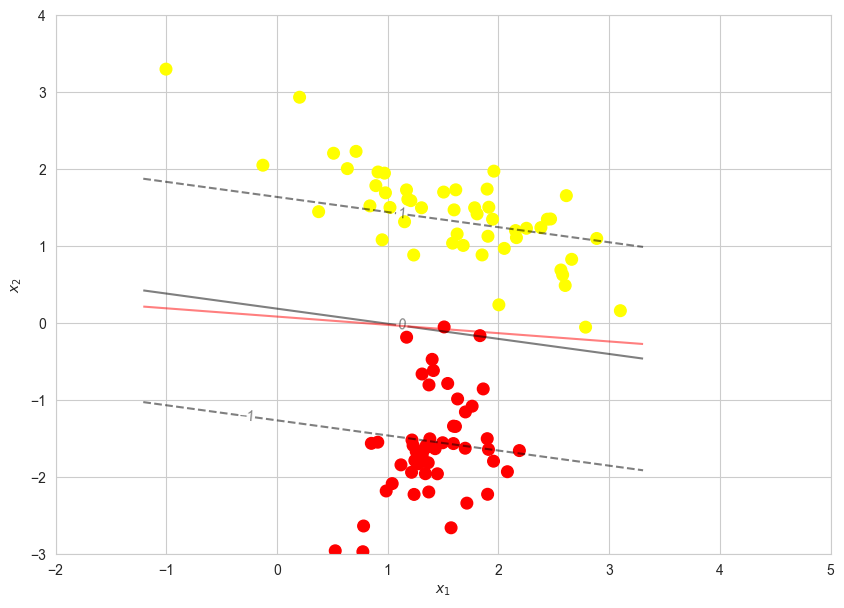

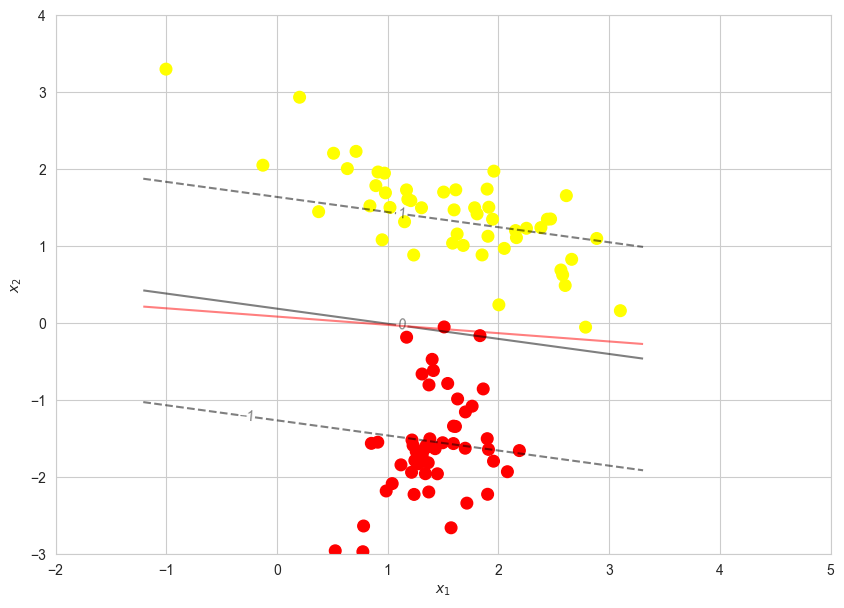

In [44]:
lin_sep_svm_demo_C(class_sep=1.5, C=0.02);

# Ядра и спрямляющие пространства

In [45]:
from sklearn.datasets import make_circles
from mpl_toolkits import mplot3d

def demo_nonlin_data():
    X, y = make_circles(n_samples=100, factor=0.1, 
                        noise=0.1, random_state=0)

    fig = plt.figure()
    ax = fig.add_subplot(1, 2, 1)

    ax.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    
    r = X[:, 0] ** 2 + X[:, 1] ** 2
    
    ax = fig.add_subplot(1, 2, 2)
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=70, cmap='autumn')
    ax.view_init(elev=30, azim=30)
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.set_zlabel('$x_1^2 + x_2^2$')

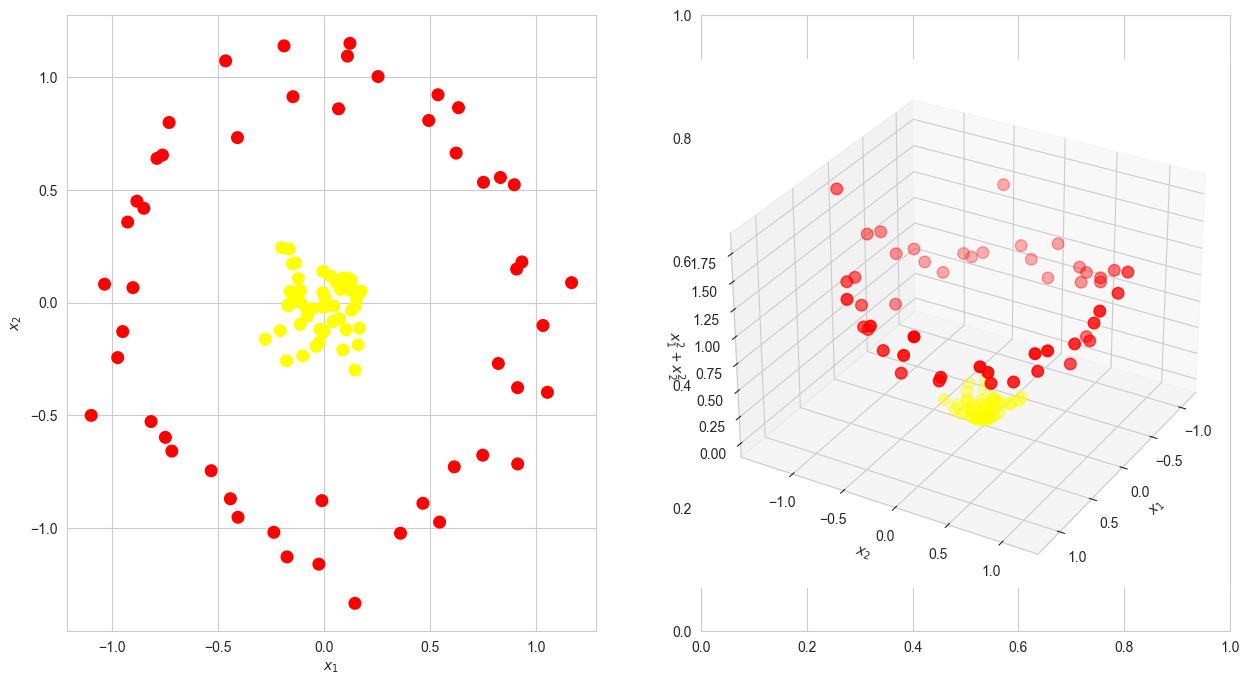

In [46]:
demo_nonlin_data();

* $\psi: X \rightarrow H$
* $H$ - пространство большей размерности, в котором классы становятся линейноразделимыми называется **спрямляющим**.
* Разделяющся гиперплоскость в таком пространстве будет линейной, но при проекции на исходное пространство $X$ - нет

* Представим, что мы строим SVM в $H$
$$\begin{cases}
\mathcal{L}(\lambda) = \sum\limits_i\lambda_i  - \frac{1}{2} \sum\limits_i\sum\limits_j \lambda_i \lambda_j  y_i y_j (\langle \psi(x_i), \psi(x_j) \rangle)  \rightarrow \max\limits_\lambda  \\
0 \leq \lambda_i \leq C \quad i=1\dots n \\
\sum\limits_i \lambda_iy_i = 0
\end{cases}$$
* Получается, нам не нужно в явном виде выражать преобразование $\psi$, нужно лишь знать результат скалярного произведения!
* Kernel trick!
* $k(x_i, x_j) = \langle \psi(x_i), \psi(x_j) \rangle$ - ядро

**Функция принятия решений:**
* Было $g(x) = w^\top x + w_0, \quad w = \sum\limits_{i:\lambda_i>0} \lambda_iy_ix_i$
* Получаем $g(x) = \sum\limits_{i:\lambda_i>0} \lambda_iy_i\langle x_i, x \rangle + w_0 = \sum\limits_{i:\lambda_i>0} \lambda_iy_i k(x_i, x) + w_0$

**Теорема Мерсера**<br/>
Функция $k(u, v)$ является ядром тогда и только тогда, когда она симметрична $k(u, v) = k(v, u)$, и неотрицательно определена, $ \int_X \int_X k(u,v) f(u)f(v) du dv \geq 0$,  $\forall f: X \rightarrow \mathbb{R}$

** Некоторые способы построения ядер **
1. Скалярное произведение - ядро, $k(u,v) = \langle u, v \rangle$
2. Константа - ядро, $k(u,v) = 1$
3. $\forall \phi: X \rightarrow \mathbb{R}$ произведение $k(u,v) =  \phi(u) \phi(v)$ - ядро
4. $k(u,v)  = \alpha_1k_1(u,v)  + \alpha_2k_2(u,v) $ - ядро
4. $k(u,v)  =  k_1(u,v) \cdot k_2(u,v) $ - ядро
5. $\forall \psi: X \rightarrow X \quad k(u,v) = k'(\psi(u),\psi(v)) $ - ядро

#### Связь ядра, нормы и расстояния
* $k(x,y)$ - ядро
* Норма $\|\psi(x)\|^2 = \langle \psi(x), \psi(x) \rangle = k(x,x)$
* Расстояние $\|\psi(x) - \psi(y)\|^2 = \langle \psi(x)-\psi(y), \psi(x)-\psi(y) \rangle = k(x,x) + k(y,y) - 2k(x,y)$

Наиболее популярны следующие ядра:

1. Линейное (linear): $$\langle x, y\rangle$$
2. Полиномиальное (polynomial): $$(\gamma \langle x, y\rangle + r)^d,$$
3. Radial basis function kernel (rbf): $$e^{(-\gamma  \cdot \|x - y\|^2)},$$ 
4. Sigmoid: $$\tanh(\gamma \langle x,y \rangle + r)$$ 

In [47]:
def lin_sep_svm_demo_kernel_C(class_sep=2, kernel='linear', C = 1, gamma=1.2, degree=2, coef0=0.0):
    X, y = make_classification(n_samples=100, n_features=2, n_informative=2, class_sep=class_sep, scale=1,
                                n_redundant=0, n_clusters_per_class=1, random_state=31)

    lin_svm = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree, coef0=0.0).fit(X, y)
    
    plt.figure(figsize=(10,7))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=70, cmap='autumn')
    plot_svc_decision_function(lin_svm)
    plt.scatter(lin_svm.support_vectors_[:, 0], lin_svm.support_vectors_[:, 1],
            s=200, facecolors='none')
    
    
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    
    plt.xlim(-2, 5)
    plt.ylim(-3, 4)

In [ ]:
from IPython.display import YouTubeVideo

In [ ]:
YouTubeVideo('3liCbRZPrZA', width=640, height=480)

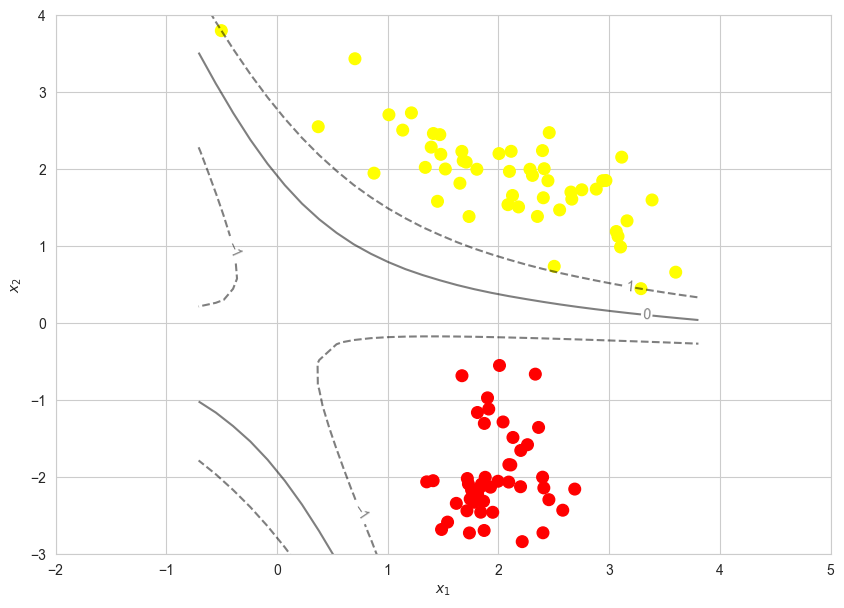

In [48]:
lin_sep_svm_demo_kernel_C(kernel=['rbf', 'linear', 'poly'][2])

# SVM для регрессии

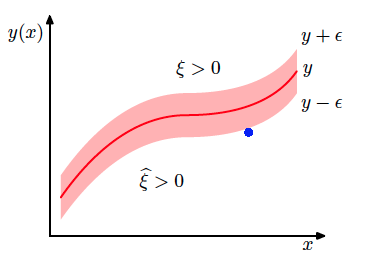

# SVM для регрессии

Переменные $\xi_i \geq 0$, $\hat \xi_i \geq 0$ (slacks):
$$
y_i \leq g(x_i) + \epsilon + \xi_i
$$
$$
y_i \geq g(x_i) - \epsilon - \hat \xi_i
$$
Задача оптимизации

$$
\begin{cases} 
   C \sum_{i=1}^n (\hat \xi_i + \xi_i) + \frac{1}{2}\|w\|^2 \rightarrow \min\limits_{w, w_0} \\
   g(x_i) - y_i \leq \epsilon + \xi_i \\
   y_i - g(x_i) \leq \epsilon + \hat{\xi}_i 
\end{cases}
$$


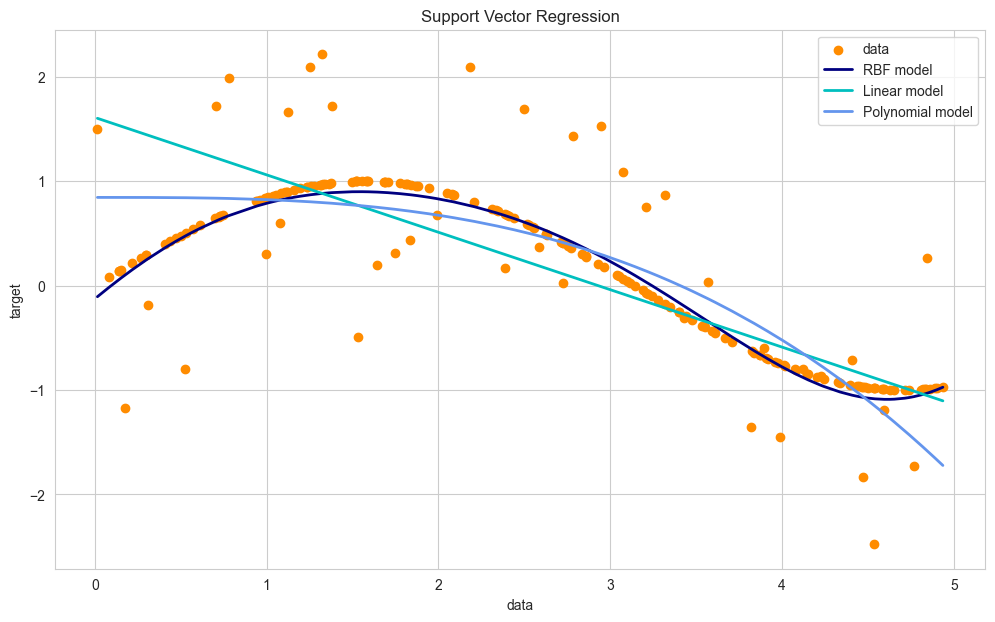

In [49]:
from sklearn.svm import SVR


X = np.sort(5 * np.random.rand(200, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - np.random.rand(40))

svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=3)

y_rbf = svr_rbf.fit(X, y).predict(X)
y_lin = svr_lin.fit(X, y).predict(X)
y_poly = svr_poly.fit(X, y).predict(X)

lw = 2
plt.figure(figsize=(12, 7))
plt.scatter(X, y, color='darkorange', label='data')
plt.plot(X, y_rbf, color='navy', lw=lw, label='RBF model')
plt.plot(X, y_lin, color='c', lw=lw, label='Linear model')
plt.plot(X, y_poly, color='cornflowerblue', lw=lw, label='Polynomial model')
plt.xlabel('data')
plt.ylabel('target')
plt.title('Support Vector Regression')
plt.legend()
plt.show()

# Titanic

In [50]:
df_train = pd.read_csv('./../data/titanic_train.csv')
df_train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.00,0,0,17463,51.86,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.07,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.13,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.07,NaN,C


In [51]:
df_test = pd.read_csv('./../data/titanic_test.csv')
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.50,0,0,330911,7.83,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.00,1,0,363272,7.00,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.00,0,0,240276,9.69,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.00,0,0,315154,8.66,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.00,1,1,3101298,12.29,NaN,S


In [52]:
survived = df_train['Survived']
df_train.drop(labels=['Survived'], axis=1, inplace=True)

df_train['Survived'] = survived
df_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,1,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S,0


In [53]:
class LabelEncoderPipelineFriendly(LabelEncoder):
    
    def fit(self, X, y=None):
        super(LabelEncoderPipelineFriendly, self).fit(X)
        
    def transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).transform(X).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return super(LabelEncoderPipelineFriendly, self).fit(X).transform(X).reshape(-1, 1)
    

class FeaturesSum(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        return np.sum(X, axis=1).reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)
    

class AgeFeature(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
        
    def transform(self, X, y=None):
        X['Initial'] = 0
        for i in X:
            X['Initial'] = X.Name.str.extract('([A-Za-z]+)\.') #lets extract the Salutations
    
        X['Initial'].replace(
            ['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don'],
            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr'],
            inplace=True
        )
        X.groupby('Initial')['Age'].mean() 

        X.loc[(X.Age.isnull()) & (X.Initial=='Mr'), 'Age'] = 33 # the average age of the person computed before
        X.loc[(X.Age.isnull()) & (X.Initial=='Mrs'), 'Age'] = 36
        X.loc[(X.Age.isnull()) & (X.Initial=='Master'), 'Age'] = 5
        X.loc[(X.Age.isnull()) & (X.Initial=='Miss'), 'Age'] = 22
        X.loc[(X.Age.isnull()) & (X.Initial=='Other'), 'Age'] = 46
        return X['Age'].to_numpy().reshape(-1, 1)

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [54]:
from sklearn.preprocessing import MinMaxScaler 

def get_sex_col(df):
    return df[['Sex']]

def get_age_name_cols(df):
    return df[['Age', 'Name']]

def get_pclass_col(df):
    return df[['Pclass']]

def get_sum_cols(df):
    return df[['Age', 'Fare']]

def get_num_cols(df):
    return df[['Fare', 'SibSp', 'Parch']]

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_pclass_col, validate=False),  OneHotEncoder(sparse=False), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_sex_col, validate=False),  LabelEncoderPipelineFriendly(), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_num_cols, validate=False), SimpleImputer(strategy='mean'), MinMaxScaler()),
    make_pipeline(FunctionTransformer(get_age_name_cols, validate=False),  AgeFeature(), MinMaxScaler()),
])

In [55]:
x_train = vec.fit_transform(df_train)
x_train.shape

(891, 8)

In [56]:
y_train = df_train['Survived']
y_train.shape

(891,)

In [ ]:
# # not to run, computationally expensive
# svr = GridSearchCV(SVR(kernel='poly'), cv=5,
#                    param_grid={"C": [1e3],
#                                "gamma": np.logspace(-2, 1, 4)})

In [57]:
from sklearn import svm
svr = svm.SVC()

In [58]:
svr.fit(x_train, y_train)

SVC()

In [59]:
accuracy_score(y_train, svr.predict(x_train))

0.8103254769921436

In [60]:
svc = SVC(probability=True)

In [61]:
svc.fit(x_train, y_train)

SVC(probability=True)

In [62]:
y_pred = svc.predict_proba(x_train)

In [63]:
y_pred

array([[0.83105442, 0.16894558],
       [0.14924403, 0.85075597],
       [0.17499183, 0.82500817],
       ...,
       [0.52340664, 0.47659336],
       [0.81201445, 0.18798555],
       [0.82351991, 0.17648009]])

In [64]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [65]:
score = roc_auc_score(y_train, 1 - y_pred[:, 0])
print(score)

0.8558410294101984


In [66]:
tpr, fpr, _ = roc_curve(y_train, y_pred[:, 0])
auc_ = auc(fpr, tpr)

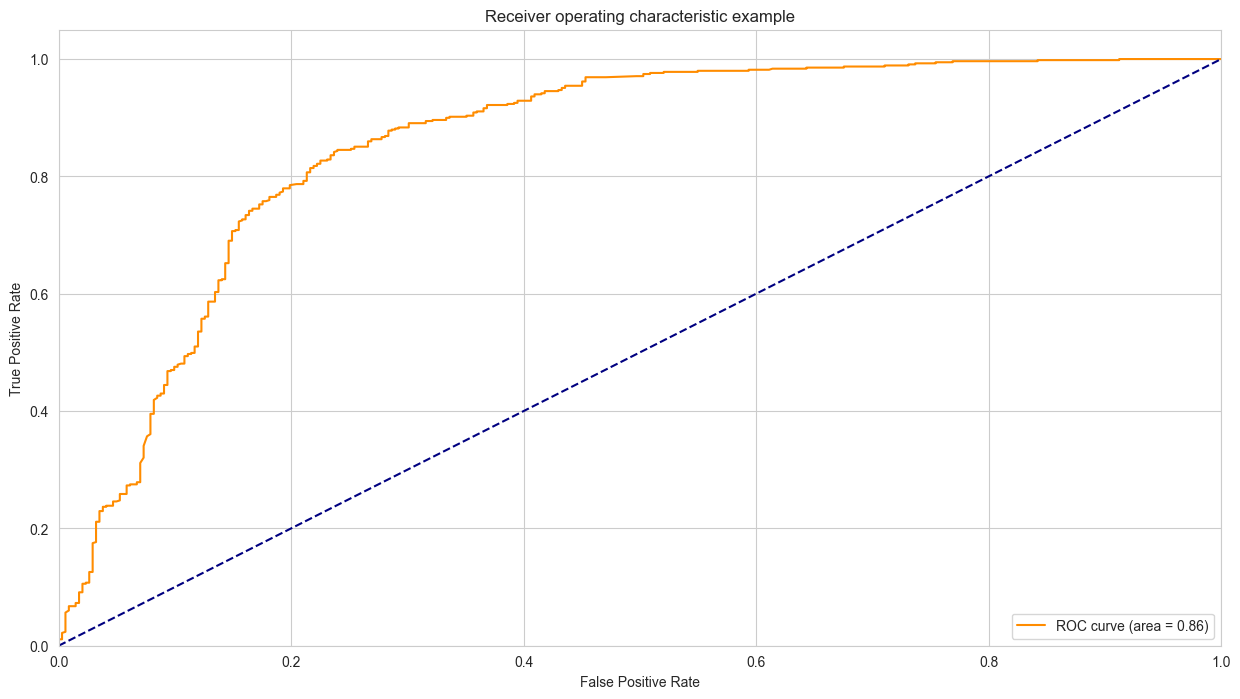

In [67]:
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()